In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.notebook import tqdm
import gpzoo
from gpzoo.kernels import NSF_RBF, batched_RBF, batched_Matern32
from gpzoo.gp import GaussianPrior, WSVGP
from gpzoo.likelihoods import PNMF, NSF2, Hybrid_NSF2
from gpzoo.utilities import train_hybrid, train_hybrid_batched, anndata_to_train_val, plot_factors, rescale_spatial_coords, add_jitter, init_softplus, whitened_KL
import squidpy as sq
import numpy as np
from sklearn.decomposition import NMF
import scanpy as sc
import random

from gpzoo.utilities import regularized_nmf, dims_autocorr
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import pickle
from sklearn.cluster import KMeans

/gladstone/engelhardt/home/lchumpitaz/gitclones/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def plot_factors(factors, X, moran_idx=None, ax=None, size=7, alpha=0.8, s=0.1, names=None):

    max_val = np.percentile(factors, 99)
    min_val = np.percentile(factors, 1)

    
    if moran_idx is not None:
        factors = factors[moran_idx]
        if names is not None:
            names = names[moran_idx]

    L = len(factors)

    if ax is None:
        fig, ax = plt.subplots(2, 6, figsize=(size*6, size*2), tight_layout=True)
        
    for i in range(L):
        
        
        curr_ax = ax[i//6, i%6]
        
        
        
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='turbo', s=s)

        curr_ax.invert_yaxis()
        if names is not None:
            curr_ax.set_title(names[i], x=0.03, y=.88, fontsize="small", c="white",
                     ha="left", va="top")
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

In [3]:
adata = sq.datasets.slideseqv2()
adata = adata.raw.to_adata()

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


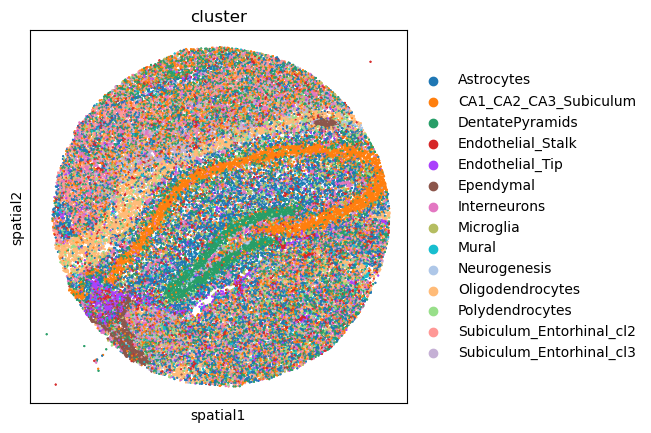

In [4]:
sq.pl.spatial_scatter(adata, color="cluster", size=1, shape=None);


<Axes: >

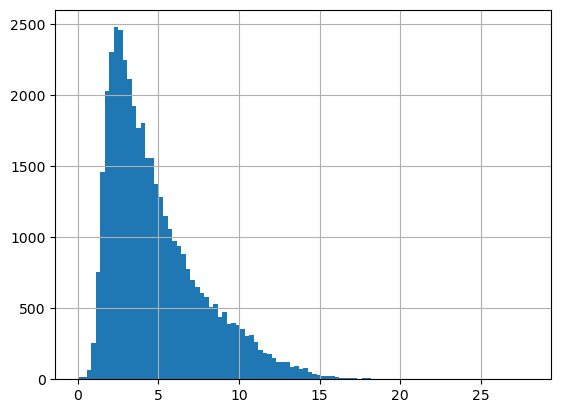

In [5]:
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
adata.obs.pct_counts_mt.hist(bins=100)


In [6]:
adata = adata[adata.obs.pct_counts_mt < 20] #from 53K to 45K
sc.pp.filter_cells(adata, min_counts=100)
sc.pp.filter_genes(adata, min_cells=10)

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:158: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_counts"] = number


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [8]:
Dtr, Dval = anndata_to_train_val(adata, sz="scanpy")

In [9]:
Y = Dtr['Y'].T
Y = Y[~adata.var.MT]
X = Dtr['X']*50
V = Dtr['sz']

In [10]:
#nmf_model = NMF(n_components=24, max_iter=100, init='random', random_state=528, alpha_H=1e-4)
nmf_model = NMF(n_components=24, max_iter=10, init='random', random_state=0, alpha_H=2e-1, alpha_W=1e-7)

In [11]:
nmf_model.fit(Y.T/V)

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  warnings.warn(


NMF(alpha_H=0.2, alpha_W=1e-07, init='random', max_iter=10, n_components=24,
    random_state=0)

In [12]:
exp_factors = nmf_model.transform(Y.T/V)/5
factors = np.log(exp_factors + 1e-2)
loadings = nmf_model.components_.T*5


/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  warnings.warn(


In [13]:
print(factors.shape)
print(loadings.shape)

(39694, 24)
(17702, 24)


In [14]:
moran_idx, moranI = dims_autocorr(np.exp(factors), X)

here_andata


In [15]:
moranI

array([0.74604912, 0.61163337, 0.60758016, 0.59804517, 0.57888866,
       0.47384094, 0.46934361, 0.46401711, 0.44428148, 0.42241853,
       0.36931834, 0.36289969, 0.33483485, 0.24356649, 0.24325957,
       0.22564549, 0.21999174, 0.21247966, 0.21158399, 0.18395021,
       0.17364227, 0.1396852 , 0.13571721, 0.09580813])

In [16]:
factors_ordered=factors[:, moran_idx]
loadings_ordered=loadings[:, moran_idx]

In [17]:
factors_ordered.max()

2.3544269

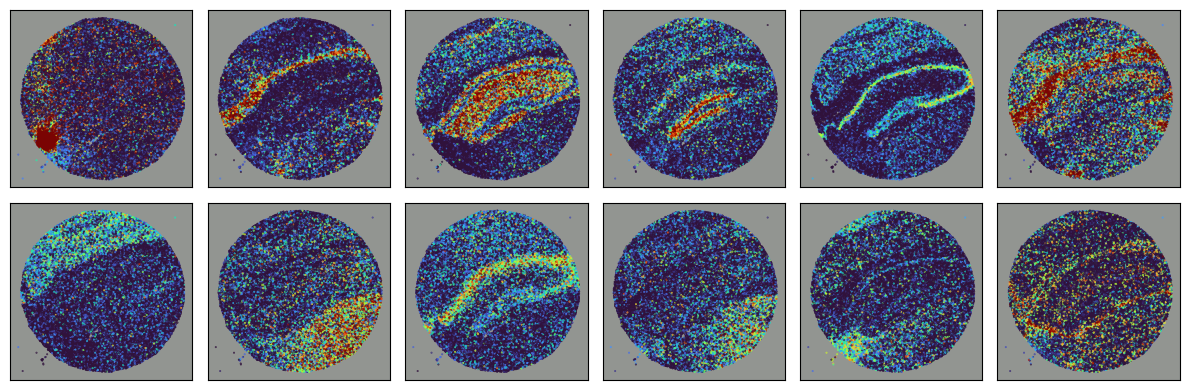

In [18]:
plot_factors(np.exp(factors.T), X, moran_idx=moran_idx[:12], ax=None, size=2, s=0.2, alpha=0.9)

In [19]:
# #zero out repeated factors
# factors_ordered[:,5]=np.random.randn(*factors_ordered[:,5].shape)
# factors_ordered[:,8]=np.random.randn(*factors_ordered[:,8].shape)


# loadings_ordered[:,5][::1]=0.0
# loadings_ordered[:,8][::1]=0.0


# factors=factors_ordered
# loadings=loadings_ordered

In [20]:
X = torch.tensor(X).type(torch.float)
Y = torch.tensor(Y).type(torch.float)

In [21]:
def build_model(Y, M=1000, L=12):
    

    
    # idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)

    kmeans = KMeans(n_clusters=M, random_state=240, n_init="auto").fit(X)
    Z = nn.Parameter(torch.tensor(kmeans.cluster_centers_).type(torch.float))
    
    kernel = batched_RBF(sigma=[1.0]*L, lengthscale=[2.0]*L)
    gp = WSVGP(kernel, M=M, jitter=1e-5)
    Kzx = kernel.forward(Z, X).contiguous()
    Kxz = torch.transpose(Kzx, -2, -1)
    Kzz = kernel.forward(Z, Z).contiguous()

    Lzz = torch.linalg.cholesky(add_jitter(Kzz, 1e-3))
    Lzzt = torch.transpose(Lzz, -2, -1)

    

    all_factors = torch.tensor(factors_ordered.T)[:L, :, None].type(torch.float)
    L1 = torch.linalg.cholesky(add_jitter(Kzx@Kxz, 1e-3))
    

    solved1 = torch.cholesky_solve(Kzx@all_factors, L1)
    print('solved1 shape:', solved1.shape)
    
    
    mu = Lzzt@solved1

    print('here')
    
    
    # gp.mu = nn.Parameter(torch.randn((L, M)).type(torch.float))
    
    gp.mu = nn.Parameter(torch.squeeze(mu).clone().detach()).type(torch.float)
    
    Lu = 1e-2*torch.eye(M).expand(L, M, M)
    gp.Lu = nn.Parameter(Lu.clone().detach())
    
    gp.Z = nn.Parameter(Z, requires_grad=False)

    prior = GaussianPrior(Y, L=L)
    prior.mean = nn.Parameter(torch.squeeze(torch.tensor(factors_ordered[:, L:].T)).type(torch.float))

    

    model = Hybrid_NSF2(gp, prior, Y, L=L, T=L)


    model.sf.W = nn.Parameter(torch.tensor(init_softplus(loadings_ordered)[:, :L]).type(torch.float)) 
    model.cf.W = nn.Parameter(torch.tensor(init_softplus(loadings_ordered)[:, L:]).type(torch.float)) 


    model.V = nn.Parameter(torch.squeeze(torch.tensor(init_softplus(V)).type(torch.float))) 
    
    model.to(device)
    return model

In [22]:
def build_model_scratch(Y, M=1000, L=10):
    

    
    idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)

    Z = nn.Parameter(X[idx])
    
    kernel = batched_Matern32(sigma=[1.0]*L, lengthscale=[2.0]*L)
    gp = WSVGP(kernel, M=M, jitter=1e-2)
    gp.mu = nn.Parameter(torch.randn((L, M)).type(torch.float))
    Lu = 1e-2*torch.eye(M).expand(L, M, M)
    gp.Lu = nn.Parameter(Lu.clone().detach())
    
    gp.Z = nn.Parameter(Z, requires_grad=False)

    prior = GaussianPrior(Y, L=L)

    model = Hybrid_NSF2(gp, prior, Y, L=L, T=L)
    
    model.to(device)
    return model

In [23]:
model = build_model(Y, M=3000)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5fe7822310>
Traceback (most recent call last):
  File "/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/gpzoo/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has n

solved1 shape: torch.Size([12, 3000, 1])
here


In [24]:
model.load_state_dict(torch.load('slideseq_RBF_12_factors_3000.pth'))

<All keys matched successfully>

In [25]:
model.cpu()
qF, _, _ = model.sf.prior(X, verbose=True)
mean = torch.exp(qF.mean).detach().numpy()

calculating kernels
calculating cholesky
calculating W
calculating cov_diag
calculating mean
tensor(0.0098, grad_fn=<MinBackward1>)


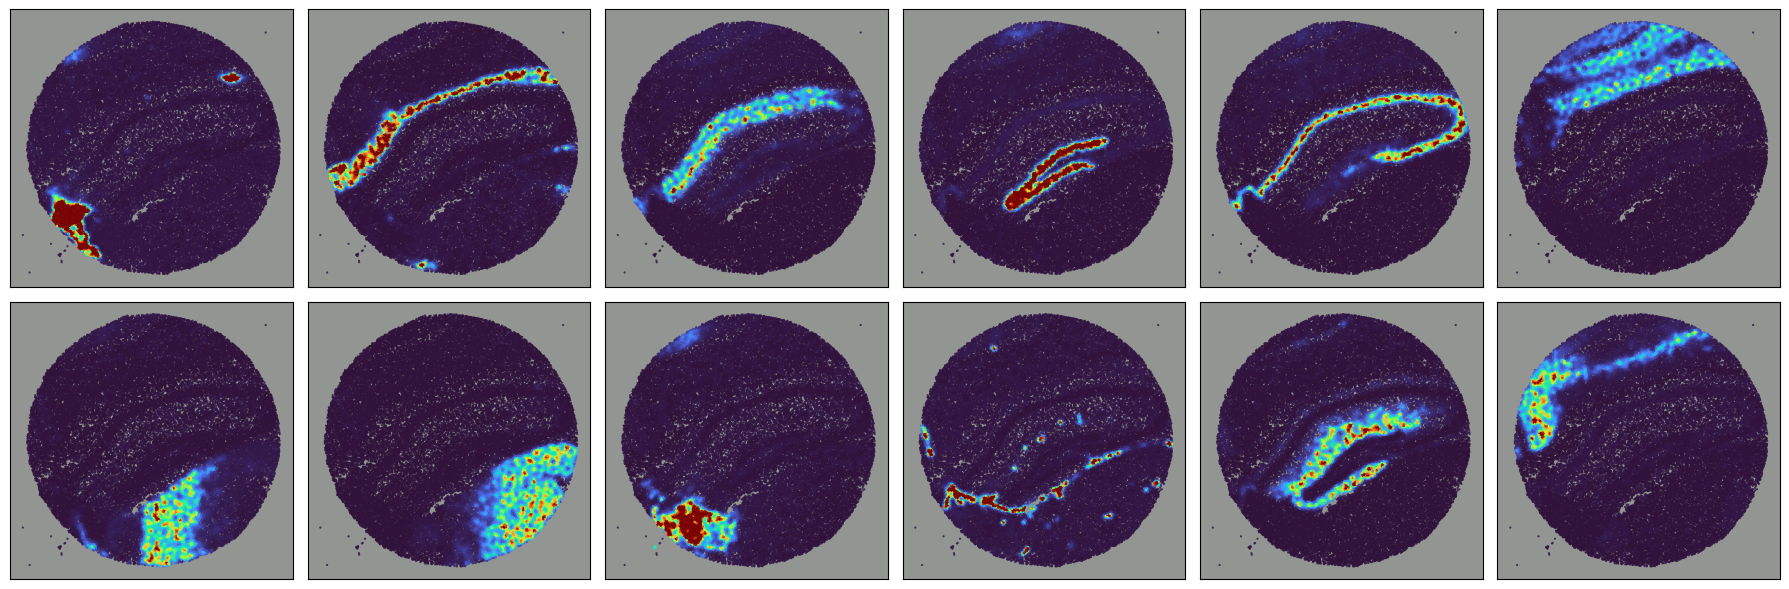

In [26]:
plot_factors(mean, X, moran_idx=None, ax=None, size=3, s=0.3, alpha=0.9)

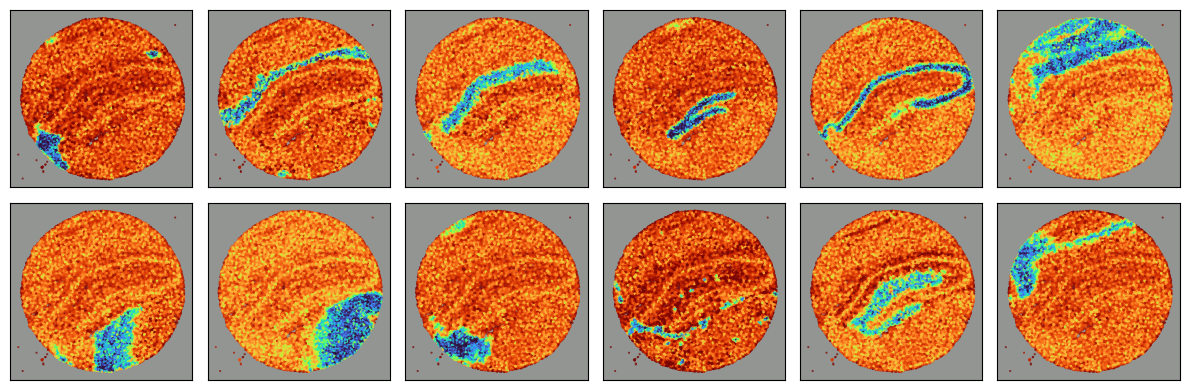

In [27]:
scale = qF.scale.detach()
plot_factors(scale, X, moran_idx=None, ax=None, size=2, s=0.2, alpha=0.9)

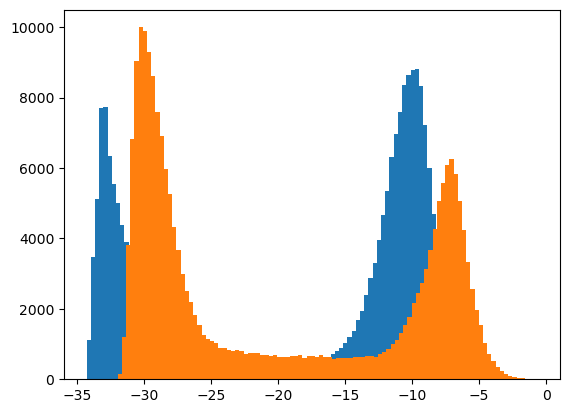

In [28]:
loadings_sf = torch.nn.functional.softplus(model.sf.W).detach().cpu()
loadings_cf = torch.nn.functional.softplus(model.cf.W).detach().cpu()

plt.hist(torch.log(loadings_sf.view(-1)), bins=100);
plt.hist(torch.log(loadings_cf.view(-1)), bins=100);

In [28]:
# in case of nans, replace with random number.
# this rarely happens but it's useful to have a function to handle it.
# with torch.no_grad():
#     model.sf.prior.mu[4].view(-1)[:] = torch.randn(len(model.sf.prior.mu[4]))

In [29]:
moran_idx, moranI = dims_autocorr(mean.T, X)
moranI

here_andata


array([0.97540064, 0.97524349, 0.97509242, 0.97439696, 0.96631508,
       0.96192353, 0.95863719, 0.95710514, 0.95524547, 0.94932904,
       0.93201736, 0.90253716])

In [30]:
X_train = X.to(device)
Y_train = Y.to(device)

In [31]:
def model_grads(model):
    model.sf.prior.kernel.sigma.requires_grad = False
    model.sf.prior.kernel.lengthscale.requires_grad = False
    model.sf.prior.Z.requires_grad=False
    model.sf.prior.mu.requires_grad=True
    model.sf.prior.Lu.requires_grad=True
    model.sf.W.requires_grad=True

    model.cf.prior.mean.requires_grad=True
    model.cf.prior.scale.requires_grad=True
    model.cf.W.requires_grad=True

    model.cf.prior.scale_pf = 0.2
    
    
    model.V.requires_grad=False

In [32]:
model_grads(model)

In [33]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

In [34]:
def train_batched(model, optimizer, X, y, device, steps=200, E=20, batch_size=1000, **kwargs):
    losses = []
    
    means = []
    scales = []
    idxs = []
    
    for it in tqdm(range(steps)):
        
        idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=batch_size, replacement=False)
        
        
        optimizer.zero_grad()
        pY, qF, qU, pU, qF2, pF2 = model.forward_batched(X=X, idx=idx, E=E, **kwargs)

        logpY = y[:, idx]*torch.log(pY.rate) - pY.rate

        ELBO = (logpY).mean(axis=0).sum()
        ELBO -= torch.sum(torch.vmap(whitened_KL)(qU.mean, qU.scale_tril))
        # ELBO -= torch.sum(distributions.kl_divergence(qU, pU))
        ELBO -= torch.sum(distributions.kl_divergence(qF2, pF2))
        loss = -ELBO

        loss += 20.0*torch.sum(model.sf.prior.kernel.lengthscale**2) 
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        if (it%10)==0:
            idxs.append(idx.detach().cpu().numpy())
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())
    
    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()
        
    return losses, means, scales, idxs

In [35]:
steps = 2000
model.to(device)

Hybrid_NSF2(
  (sf): PoissonFactorization(
    (prior): WSVGP(
      (kernel): batched_RBF()
    )
  )
  (cf): PoissonFactorization(
    (prior): GaussianPrior()
  )
)

In [36]:
model.sf.prior.jitter=1e-6

In [37]:
losses, means, scales, idxs = train_batched(model, optimizer, X_train, Y_train, device, steps=steps, E=3, batch_size=7000)

  0%|          | 0/2000 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.39 GiB. GPU 0 has a total capacity of 23.50 GiB of which 279.06 MiB is free. Process 3977431 has 2.06 GiB memory in use. Process 176225 has 5.82 GiB memory in use. Including non-PyTorch memory, this process has 14.42 GiB memory in use. Process 1080742 has 916.00 MiB memory in use. Of the allocated memory 13.48 GiB is allocated by PyTorch, and 649.47 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [224]:
# torch.save(model.state_dict(), 'slideseq_RBF_12_factors_3000.pth')

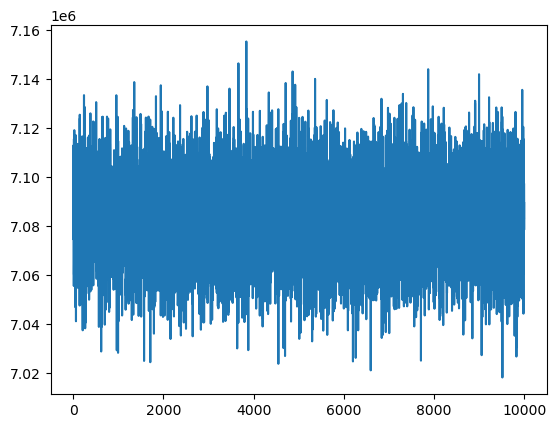

In [209]:
plt.plot(losses)

In [222]:
model.sf.prior.kernel.lengthscale

Parameter containing:
tensor([1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
        1.5000, 1.5000, 1.5000])

In [223]:
# with torch.no_grad():
#     model.sf.prior.kernel.lengthscale.view(-1)[:] = 2.0

In [165]:
with torch.no_grad():
    print(model.cf.prior.mean.shape)

torch.Size([12, 39694])


In [166]:
model.sf.prior.kernel.lengthscale

Parameter containing:
tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.], device='cuda:0')

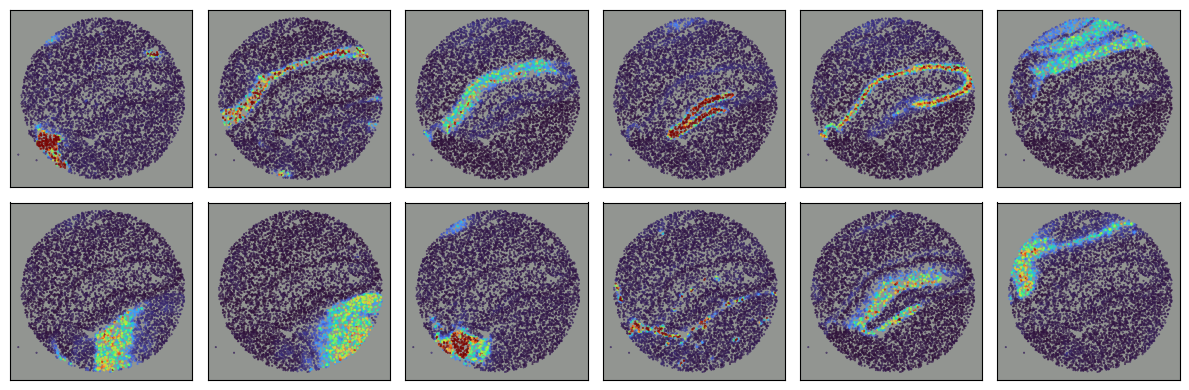

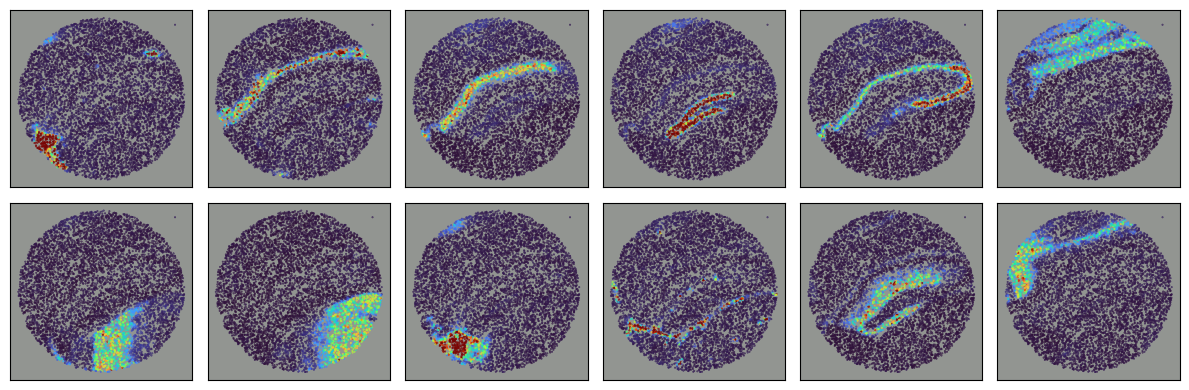

In [210]:
plot_factors(means[0], X[idxs[0]], moran_idx=None, ax=None, size=2, s=0.2, alpha=0.9)
plot_factors(means[-1], X[idxs[-1]], moran_idx=None, ax=None, size=2, s=0.2, alpha=0.9)

In [211]:
model.cpu()

qF2, _ = model.cf.prior()
means2 = torch.exp(qF2.mean).detach().numpy()

In [212]:
moran_idx, moranI = dims_autocorr(means2.T, X)
moranI

here_andata


array([ 0.58607716,  0.55851097,  0.55521958,  0.37078691,  0.23207136,
        0.2113054 ,  0.08695605,  0.04826104,  0.02734544,  0.00911603,
        0.00731732, -0.00097488])

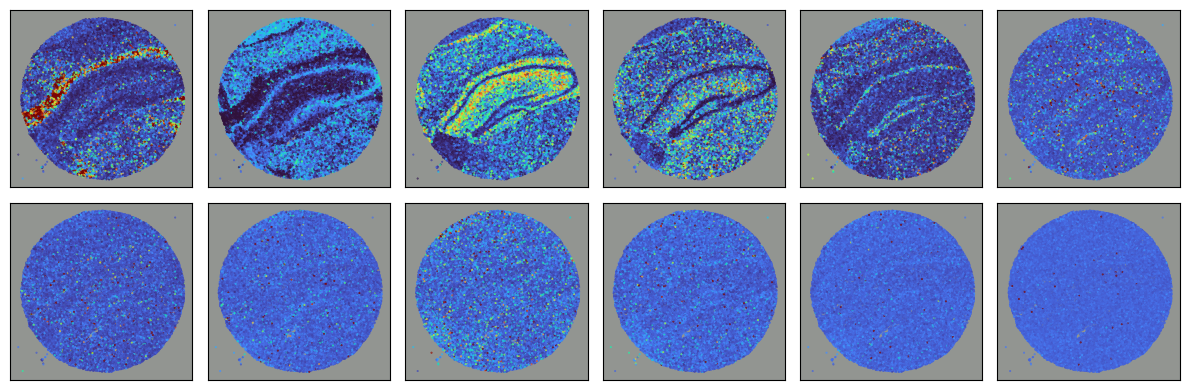

In [213]:
plot_factors(means2, X, moran_idx=moran_idx, ax=None, size=2, s=0.2, alpha=0.9)


In [175]:
loadings = torch.nn.functional.softplus(model.sf.W)

loadings_softmax = torch.nn.functional.softmax(loadings, dim=1)


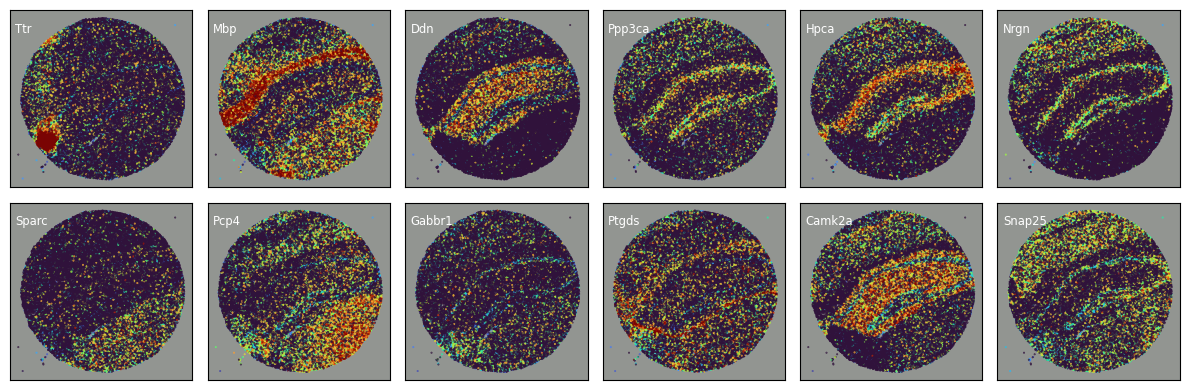

In [176]:
names = adata.var.index[loadings_softmax.argmax(dim=0)]
plot_factors(Y[loadings_softmax.argmax(dim=0)], X, moran_idx=None, ax=None, size=2, s=0.2, alpha=0.9, names=names)

In [ ]:
size=2
fig, ax = plt.subplots(2, 6, figsize=(size*6, size*2), tight_layout=True)


def update(iteration):
    for element in ax:
        for element in element:
            element.cla()
        
    curr_factor = means[iteration]
    curr_idx = idxs[iteration]

    
    
    plot_factors(curr_factor, X[curr_idx], ax=ax, size=2, s=0.2, alpha=0.9)

#     fig.suptitle(f"Iteration: {iteration}, Loss: {losses[iteration*10]:0.2f}")
#     fig.tight_layout()
    print('hi', iteration)


anim = FuncAnimation(fig, update, frames=np.arange(0, 2400, 2), interval=100)
plt.close()
# anim.save('pnmf.mp4',
#          writer=animation.FFMpegWriter(fps=50, bitrate=2000, codec='h264'),
#          dpi=50)
anim.save("slideseq_12_5000.mp4", fps=60, dpi=100)

hi 0
hi 0
hi 2
hi 4
hi 6
hi 8
hi 10
hi 12
hi 14
hi 16
hi 18
hi 20
hi 22
hi 24
hi 26
hi 28
hi 30
hi 32
hi 34
hi 36
hi 38
hi 40
hi 42
hi 44
hi 46
hi 48
hi 50
hi 52
hi 54
hi 56
hi 58
hi 60
hi 62
hi 64
hi 66
hi 68
hi 70
hi 72
hi 74
hi 76
hi 78
hi 80
hi 82
hi 84
hi 86
hi 88
hi 90
hi 92
hi 94
hi 96
hi 98
hi 100
hi 102
hi 104
hi 106
hi 108
hi 110
hi 112
hi 114
hi 116
hi 118
hi 120
hi 122
hi 124
hi 126
hi 128
hi 130
hi 132
hi 134
hi 136
hi 138
hi 140
hi 142
hi 144
hi 146
hi 148
hi 150
hi 152
hi 154
hi 156
hi 158
hi 160
hi 162
hi 164
hi 166
hi 168
hi 170
hi 172
hi 174
hi 176
hi 178
hi 180
hi 182
hi 184
hi 186
hi 188
hi 190
hi 192
hi 194
hi 196
hi 198
hi 200
hi 202
hi 204
hi 206
hi 208
hi 210
hi 212
hi 214
hi 216
hi 218
hi 220
hi 222
hi 224
hi 226
hi 228
hi 230
hi 232
hi 234
hi 236
hi 238
hi 240
hi 242
hi 244
hi 246
hi 248
hi 250
hi 252
hi 254
hi 256
hi 258
hi 260
hi 262
hi 264
hi 266
hi 268
hi 270
hi 272
hi 274
hi 276
hi 278
hi 280
hi 282
hi 284
hi 286
hi 288
hi 290
hi 292
hi 294
hi 296
hi 298
